Introduction
=========

In this notebook, you will find some code for simulating and training spiking neural networks via PyTorch.
It starts with some code cells below that just contain helper functions that you do not have to look at too closely. 
The important part of the notebook starts with the section "Computing with spiking neural networks".
From this point on, it will be important to understand the equations, text, and code to some degree.
I have added a bit of explanatory text with some links to useful wikipedia/scholarpedia articles, for the crucial concepts, should you not know them already. If you have any questions, you can always ask , of course! 

To run the code below, you will have to install the following Python packages:

1. NumPy
2. matplotlib
3. PyTorch (see installation instructions at https://pytorch.org/)
4. H5Py
6. SciPy
7. jupyter notebook

I recommend setting up an anaconda environment (https://conda.io/projects/conda/en/latest/user-guide/index.html) with Python 3.10 and installing all the software listed above into it. You should be able to install pretty much all of the packages via simple `pip install <package name>` calls.

Have fun!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as pt
import h5py as hp
import os
from scipy.stats import cauchy
from time import perf_counter
%matplotlib inline

# check which device to use
device = "cuda" if pt.cuda.is_available() else "cpu"
pt.set_default_dtype(pt.float64)

In [2]:
def lorentzian(n: int, eta: float, delta: float, lb: float, ub: float):
    samples = np.zeros((n,))
    for i in range(n):
        s = cauchy.rvs(loc=eta, scale=delta)
        while s <= lb or s >= ub:
            s = cauchy.rvs(loc=eta, scale=delta)
        samples[i] = s
    return samples

In [3]:
def get_spiking_dataset(data_path: str) -> dict:
    
    train_data = hp.File(os.path.join(data_path, "shd_train.h5"))
    test_data = hp.File(os.path.join(data_path, "shd_test.h5"))
    results = {}
    results["X_train"] = train_data["spikes"]
    results["y_train"] = train_data["labels"]
    results["X_test"] = test_data["spikes"]
    results["y_test"] = test_data["labels"]
    
    return results

In [4]:
def data_generator(X, y, n_samples: int, n_steps: int, n_inp: int, max_time: float, shuffle: bool = True):
    """ This generator takes a spike dataset and generates spiking network input. 

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time,neuron) tuples
        y: The labels
    """

    labels = np.array(y, dtype=np.int32)
    sample_index = np.arange(n_samples)

    firing_times = X['times']
    units_fired = X['units']
    
    time_bins = np.linspace(0, max_time, num=n_steps)

    if shuffle:
        np.random.shuffle(sample_index)

    counter = 0
    while counter<n_samples:
        
        idx = sample_index[counter]
        spike_times = pt.LongTensor(np.digitize(firing_times[idx], time_bins))
        inp_neurons = pt.LongTensor(np.asarray(units_fired[idx], dtype=np.int32))
        X_batch = pt.zeros([n_steps, n_inp])
        X_batch[spike_times, inp_neurons] = 1.0
        y_batch = pt.tensor([labels[idx]], dtype=pt.long)

        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1

In [5]:
class Spike(pt.autograd.Function):

    slope = 50.0
    center = pt.tensor(1.0)

    @staticmethod
    def forward(ctx, x: pt.Tensor) -> pt.Tensor:
        ctx.save_for_backward(x)
        return pt.heaviside(x, Spike.center)

    @staticmethod
    def backward(ctx, grad_output: pt.Tensor) -> pt.Tensor:
        x, = ctx.saved_tensors
        return grad_output/(1.0 + Spike.slope*pt.abs(x))**2
    
spike_fn = Spike.apply

Computing with spiking neural networks
==============================

Model definition
---------------------

We would like to study how networks of recurrently coupled spiking neurons can compute, i.e. learn to represent consistent input-output relationships, and how their ability to compute depends on the network-intrinsic dynamics.
To this end, we study networks of recurrently coupled [quadratic integrate-and-fire (QIF) neurons](http://www.scholarpedia.org/article/Ermentrout-Kopell_canonical_model), which is a one-dimensional neuron model.
It's only state variable, the membrane potential $v$, is governed by the following differential equation:

$$\tau \dot v = v^2 + I(t),$$

with membrane time constant $\tau$ and a lumped input to the neuron $I(t)$.
This neuron is said to spike, if $v > v_{theta}$.
At this point, a spike is counted and the membrane potential is reset to a reset potential $v_r$.
We consider networks of intercoupled QIF neurons, and we further enrich the single QIF neuron dynamics by adding a [spike-frequency adaptation (SFA)](http://www.scholarpedia.org/article/Spike_frequency_adaptation) term (see [Gast et al. 2020 Neural Computation](https://direct.mit.edu/neco/article/32/9/1615/95603/A-Mean-Field-Description-of-Bursting-Dynamics-in) for a study of this type of network). 
The network dynamics are described by

$$$\tau \dot v_i = v_i^2 + \sum_{j=1}^N W_{ij} s_j + I_{ext}(t) + eta_i - \alpha u_i,$$
$$\tau_u \dot u_i = -u_i + \tau_u s_i,$$
$$\tau_s \dot s_i = -s_i + \tau_s \sum_{t_k} \delta(t-t_i^k),$$

with SFA variable $u$, and synaptic activation $s$.
The spike times of the $i$-th neuron are denoted as $t_i^k$ and $\delta$ refers to the Dirac delta function.

Model implementation
-----------------------------

The code below implements the right-hand side of the above differential equation system, where the state variables $v$, $u$, and $s$ are vectors of length $N$.

In [6]:
def snn_rhs(v: pt.Tensor, u: pt.Tensor, s: pt.Tensor, spikes: pt.Tensor, W: pt.Tensor, I_ext: pt.Tensor, 
            etas: pt.Tensor, tau: float, tau_u: float, tau_s: float, alpha: float) -> tuple:
    
    reset = spikes.detach()
    
    dv = (v**2 + etas + I_ext + W @ s - alpha*u) / tau - 2*reset*v
    du = -u/tau_u + spikes
    ds = -s/tau_s + spikes
    
    return dv, du, ds

Note that there is an additional term `-2*reset*v` in the first equation, which implements a simplified implementation of the reset of the membrane potential variable around a spike.

Model integration
-----------------------

In order to get the actual values of the state variables $v$, $u$, and $s$ at a time point $t$, we will have to integrate those equations numerically. Since our equations require a manual counting of spikes, we choose the most simple method to do this: The [forward Euler method](https://en.wikipedia.org/wiki/Euler_method).
The function below implements Euler integration of the differential equation system, including a spiking mechanism. 

In [7]:
def snn_integration_step(I_ext: pt.Tensor, v: pt.Tensor, u: pt.Tensor, s: pt.Tensor, dt: float, v_peak: float, W: pt.Tensor, *args) -> tuple:
    
    spikes = spike_fn(v - v_peak)
    dv, du, ds = snn_rhs(v, u, s, spikes / dt, W, I_ext, *args)
    v_new = v + dt * dv
    u_new = u + dt * du
    s_new = s + dt * ds
    
    return v_new, u_new, s_new    

The function call `spike_fn(v-v_peak)` detects when a spike should be counted for each neuron.
We defined the function in one of the above cells, where we define the `Spike` class.
This `Spike` class takes care of detecting spikes and approximating the gradient of the spike generation with respect to the input.

Parameter optimization
-------------------------------

In order to train these spiking neuron networks to perform a computation, we will adjust its intrinsic weights $W_{ij}$ according to some optimization criterion. 
We will define a target output, that we want the network to produce and calculate the error between the actual network output and the target output. We will then use [error backpropagation](https://en.wikipedia.org/wiki/Backpropagation) in combination with some [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)-based algorithm to adjust the weights according to how strongly they affect the error. 
This requires to calculate the gradient of the error with respect to each model variable and parameter.
While most of this is automatically done by PyTorch, we have to tell the automatic gradient calculation methods of PyTorch what to do around the discontinuous spikes, where the automatic gradient calculation will fail.
This is, what the `Spike` class is for.

Network parameters
---------------------------

To move forward, let's define the network parameters first.
To this end, we will feed input into the spiking network via an input layer, and project its output to a readout layer.
For each of these projections, we will define connectivity matrices.


In [8]:
# model parameters
N = 200
tau = 10e-3
eta = 0.02
Delta = 0.01
tau_u = 100e-3
alpha = 0.05
tau_s = 20e-3
J = 0.2

# get a neuron-specific background input
etas = lorentzian(N, eta=eta, delta=Delta, ub=eta+2.0, lb=eta-2.0)

# collect all model parameters
args = (pt.tensor(etas, device=device), tau, tau_u, tau_s, alpha)

# network connectivity
W = np.random.rand(N, N)
for idx in range(N):
    W[idx, :] *= J/np.sum(W[idx, :])
W = pt.tensor(W, device=device, requires_grad=True)

# readout layer
n_readout = 20
W_out = np.random.randn(n_readout, N)
W_out = pt.tensor(W_out, device=device, requires_grad=True)
readout_fn = pt.nn.LogSoftmax(dim=0)

# input layer
n_inp = 700
W_in = np.random.randn(N, n_inp)
W_in = pt.tensor(W_in, device=device, requires_grad=True)

Forward simulation of the model dynamics
--------------------------------------------------------

The code cell below defines a function which simulates the dynamics of the full model, including the input and readout layers, given some extrinsic input, and returns the readout layer activation as well as the spiking activity on the spiking neural network.  

In [9]:
def snn_run(X: pt.Tensor, step_size: float, dt: float, v_peak: float, *args, **kwargs):
    
    N = W.shape[0]
    n_steps = X.shape[0]
    integration_steps = int(step_size/dt)
    
    # initialize network state
    v = kwargs.pop("v", pt.zeros((N,), device=device))
    u = kwargs.pop("u", pt.zeros((N,), device=device))
    s = kwargs.pop("s", pt.zeros((N,), device=device))
    
    readout, s_rec = [], []
    for step in range(n_steps):
        
        # calculate network response to input
        inp = W_in @ X[step, :]
        for _ in range(integration_steps):
            v_new, u_new, s_new = snn_integration_step(inp, v, u, s, dt, v_peak, W, *args)
            v = v_new
            u = u_new
            s = s_new
        out = W_out @ s
        
        # save network response
        readout.append(out)
        s_rec.append(s)
    
    final_state = {"v": v, "u": u, "s": s}
    return pt.stack(readout, dim=0), pt.stack(s_rec, dim=0), final_state

To test this function and find a set of parameters that leads to reasonable model behavior (i.e. neurons should not be completely silent but also not spike all the time), let's perform a small forward simulation of the model dynamics and look at its behavior.

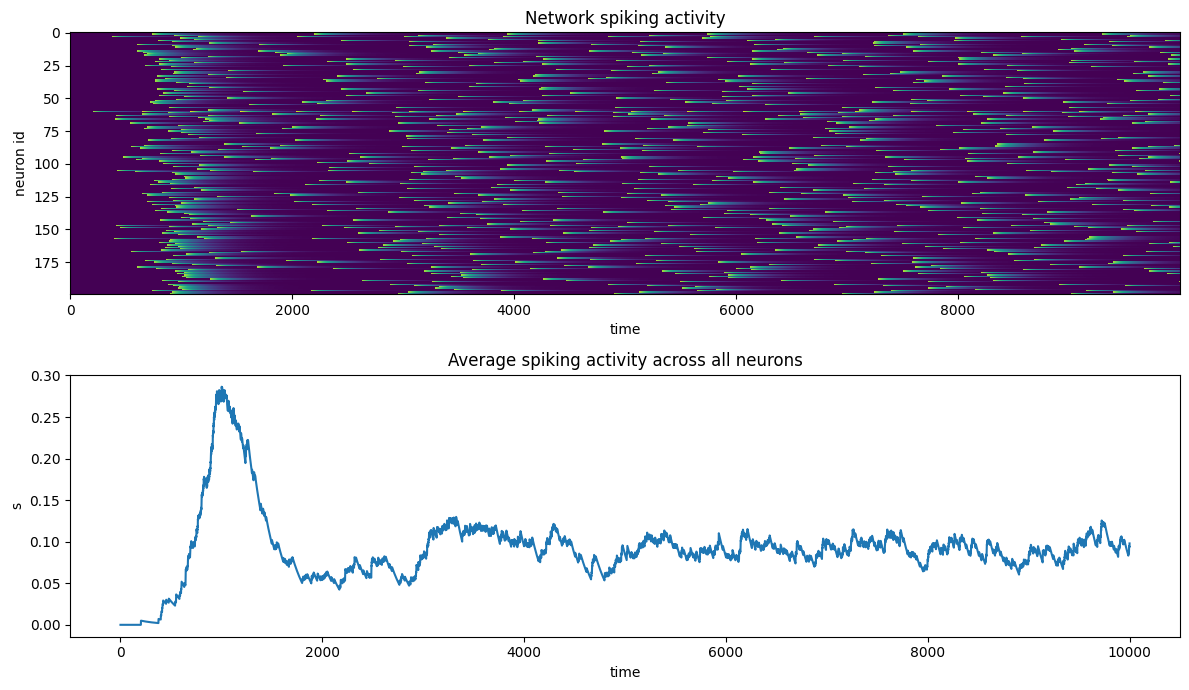

In [10]:
# simulation parameters
T = 1.0
dt = 1e-4
steps = int(T/dt)
inp = pt.zeros((steps, n_inp,), device=device)
v_peak = 1.0

# simulation
with pt.no_grad():
    readout, s_rec, init_state = snn_run(inp, dt, dt, v_peak, *args)
signal = s_rec.cpu().numpy()

# plotting
fig, axes = plt.subplots(nrows=2, figsize=(12, 7))
ax = axes[0]
ax.imshow(signal.T, aspect="auto", interpolation="none")
ax.set_title("Network spiking activity")
ax.set_xlabel("time")
ax.set_ylabel("neuron id")
ax = axes[1]
ax.plot(np.mean(signal, axis=1))
ax.set_title("Average spiking activity across all neurons")
ax.set_xlabel("time")
ax.set_ylabel("s")
plt.tight_layout()

Training the model on a spoken digit recognition task
-----------------------------------------------------------------------

After we found a nice set of parameters that leads to well-behaved model dynamics, let's move forward and train the model on a particular task.
Specificallty, we would like to train the model to learn the Spiking Heidelberg Digits dataset (https://compneuro.net/posts/2019-spiking-heidelberg-digits/). This dataset uses a sophisticated cochlear model to generate the spike data corresponding to audio recordings of spoken digits (for examples see https://github.com/fzenke/spytorch/blob/main/notebooks/SpyTorchTutorial4.ipynb).

Before executing the code below, you should download the data set at https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/.

In the code below, we use the functions that we defined in the beginning of the notebook to load the training and test data from file.
We then create a PyTorch routine to optimize all weight matrices in the network such that the readout layer of the model shows the strongest activation for the readout unit that corresponds to the digit (1-20) that the spiking input pattern was generated for.

You can play around with meta parameters such as the learning rate `lr`, the number of training epochs `n_epochs`, or the regularization strengths `epsilon`.

In [ ]:
# training parameters to play with
lr = 0.05
n_epochs = 10
n_samples = 100
v_peak = 1.0
epsilon_spikes = 1e-6
epsilon_nospikes = 1e-3
min_spike_rate = 5e-2
betas = (0.9, 0.999)

# initial condition of the network 
# (currently this chooses the initial state of the system at each trial as the final state of the system after the simulation performed above)
kwargs = {"v": init_state["v"], "u": init_state["u"], "s": init_state["s"]}

# training parameters that should be left untouched
max_time = 1.4
n_steps = 100
input_step_size = max_time/n_steps

# torch loss and optimizer (feel free to play around with the optimizer as well)
loss_fn = pt.nn.NLLLoss()
optim = pt.optim.Adamax([W, W_out, W_in], lr, betas=betas)

# get data
data = get_spiking_dataset("/home/rgf3807/OneDrive/data/SHD")

losses = []
for epoch in range(n_epochs):
    
    t0 = perf_counter()
    epoch_loss = []
    predictions, targets = [], []
    for X, y in data_generator(data["X_train"], data["y_train"], n_samples, n_steps, n_inp, max_time, shuffle=True):
        
        # forward simulation of SNN activity for a single training sample
        readout, spikes, _ = snn_run(X, input_step_size, dt, v_peak, *args, **kwargs)
        
        # calculate loss on the training sample
        readout_max, _ = pt.max(readout, 0)
        prediction = readout_fn(pt.reshape(readout_max, (1, readout_max.shape[0])))
        reg_spikes = epsilon_spikes*pt.mean(spikes)
        reg_nospikes = epsilon_nospikes*pt.mean(pt.nn.functional.relu(min_spike_rate - pt.sum(spikes, dim=0)))
        loss = loss_fn(prediction, y) + reg_spikes + reg_nospikes
        
        # optimization step
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        # save results
        epoch_loss.append(loss.item())
        predictions.append(np.argmax(prediction.cpu().detach().numpy()))
        targets.append(y.cpu().detach().numpy()[0])
    
    # print progress
    losses.append(np.mean(epoch_loss))
    t1 = perf_counter()
    print(f"Finished training epoch #{epoch+1} after {t1-t0}s. Current loss: {losses[-1]}")
    
print(f"Training finished! Final loss: {losses[-1]} (initial loss: {losses[0]}).")

Now that the training period finished, lets have a quick look at an example input spiking pattern and the spiking response it triggered in the network:

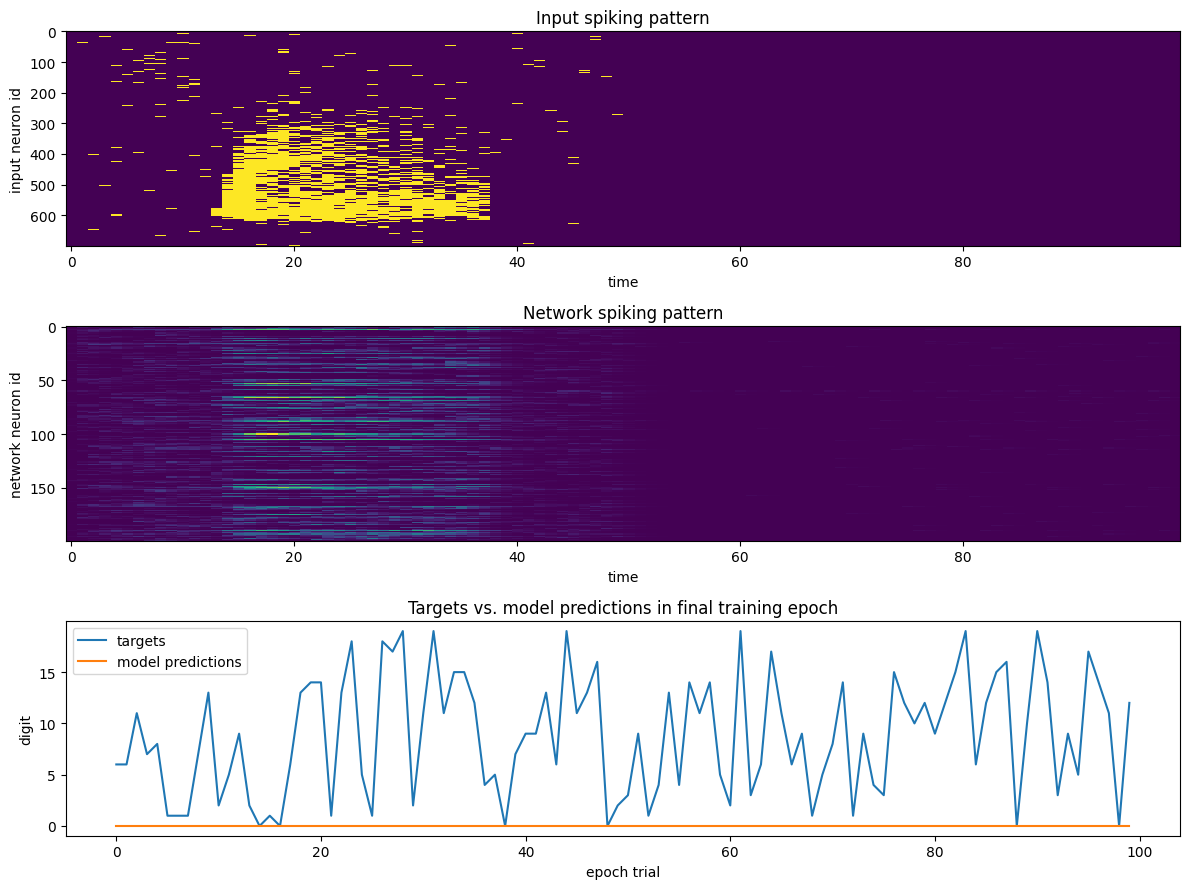

In [12]:
fig, axes = plt.subplots(nrows=3, figsize=(12, 9))

ax = axes[0]
ax.imshow(X.cpu().detach().numpy().T, aspect="auto", interpolation="none")
ax.set_title("Input spiking pattern")
ax.set_xlabel("time")
ax.set_ylabel("input neuron id")
ax = axes[1]
ax.imshow(spikes.cpu().detach().numpy().T, aspect="auto", interpolation="none")
ax.set_title("Network spiking pattern")
ax.set_xlabel("time")
ax.set_ylabel("network neuron id")
ax = axes[2]
ax.plot(targets, label="targets")
ax.plot(predictions, label="model predictions")
ax.legend()
ax.set_title("Targets vs. model predictions in final training epoch")
ax.set_xlabel("training sample")
ax.set_ylabel("digit")
plt.tight_layout()

What you want to make sure is, that the epoch loss is decreasing, and that there is some kind of spiking response in the network.  

Evaluating the model performance on the test data set
------------------------------------------------------------------------

As an exercise to better understand the code above, you can implement code below which tests the performance of the model on the test data.
The data has already been loaded, the loss function is defined, and the model equations and simulation function as well.
Let's put these things together:
For each spiking input pattern of the test data set, (1) obtain the model response to the input spiking patterns, (2) calculate the loss between the target and the model response, and (3) save the loss, the target output and the model response in a list.
Then, calculate the average loss on the test data set and plot the target output and model response for a few test trials.

In [29]:
# TODO: test model performance on training data set and plot results

Future steps
-----------------

After testing out this model, getting it to perform the task well, and getting a sense for how the different parameters affect the model behavior, here is are some ideas/steps of how to turn this into a scientific study / publication / thesis:

1. Based on the simulation of the SNN dynamics, you can calculate various quantities to characterize its dynamic regime. You could calculate the Lyapunov spectrum of the system dynamics. You could simply simulate the system dynamics over a certain time interval for different initial conditions and measure how the distance between different initial conditions evolves over time throughout the simulation. Doing that systematically, while you vary a parameter of interest of the system, say the time scale of spike frequency adaptation $\tau_u$, allows you to approximate things like the level of chaoticity in the system given a certain parameterization. 

2. You can then systematically evaluate the performance of the model in the spoken digit recognition task as a function of the same parameter. You can then ask whether the level of chaoticity and the task performance are related to each other.

3. You can use the mean-field equations that describe the macroscopic dynamics of the spiking network that I derived in Gast et al. 2020 Neural Computation. These allow for a much easier and more accurate characterization of the qualitative system dynamics as you change certain parameters. In particular, you could find regimes of interest where chaos is likely to appear (around certain bifurcation points) and start a more systematic investigation there. This would allow you to map the computational capacity of the system to particular bifurcations happening at the macroscopic scale. 

4. Furthermore, you could try to find a quantity in the mean-field dynamics (such as some sort of impulse response) that is a good proxy for the level of chaoticity and/or the task performance of the system. Finding something like that would be super useful, because it would allow people in reservoir computing to use a low-dimensional mean-field model to find an operating regime where they now the performance of their network will be optimal. 

5. You could get into some more neuroscience-specific questions (still with a physical component, obviously). Questions like how are the differences in time scales in the model contributing to the level of chaoticity and task performance? Is it critical to have particularly long or short time scales in the model in order to achieve a certain level of performance? We could then discuss where these time scales might come from in the brain. Another question could be how sensitive the networks performance is to changes in its dynamic regime. Is the performance dropping dramatically when we are not in a nice, chaotic regime anymore? Are their ways to stabilize the performance by adding a bit of noise or heterogeneity to the network? How could stable computational performance be achieved in the brain, despite constant changes in its sensory input etc.? 

6. You could look closer at the changes caused by the training procedurel. How do the coupling weight changes of the training procedure affect the model dynamics? How is the fitted weight matrix different from the initial one from a graph theoretic perspective? Is it more or less clustered, for example? And can we associate any of these changes with task performance? Is a training run that achieved a certain level of weight clustering or system dynamics always better than a training run that didnt?  

We can discuss these in more detail and see what kind of question fits for you, if you wanted. I am sure there are more interesting questions to be addressed around this problem also, if you wanted to think of a different one.